In [37]:
from questllama.extensions import HybridRetriever
from shared import config as C
from tokenizers import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma

model_name=C.TOKENIZER

In [38]:
model = HybridRetriever(skill_library="skill_library")
knowledge_database = model.read_knowledge_database()

198


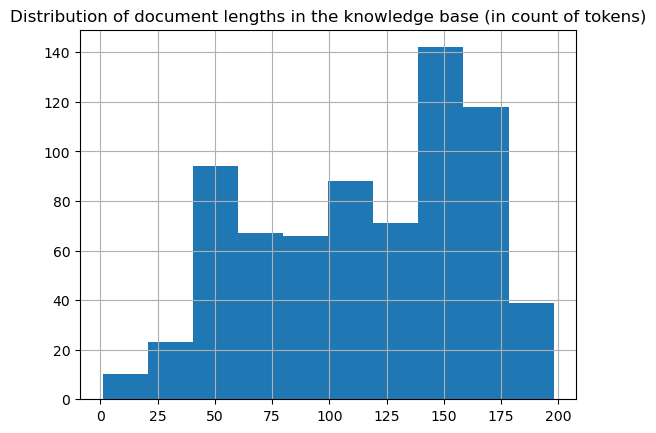

In [39]:
docs_processed = model.split_documents(512, knowledge_database, model_name)

tokenizer =  Tokenizer.from_pretrained(model_name)
lengths = [
    len(tokenizer.encode(doc.page_content)) for doc in docs_processed
]
print(max(lengths))
fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()

In [42]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

# embedding_model = HuggingFaceEmbeddings(
#     model_name=model_name,
#     multi_process=True,
#     model_kwargs={"device": "cuda"},
#     encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
# )

# KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
#     docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
# )

embedding_model = C.EMBEDDING()
KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    persist_directory=C.DB_DIR,
)


In [46]:
# embed a user query in the same space
user_query = "mineTenCobblestone()"
query_vector = embedding_model.embed_query(user_query)

In [47]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/pacmap/pacmap.py:828: UserWarning:




AttributeError: 'Chroma' object has no attribute 'index'

In [49]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [26]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='killOneCreeper'...

==================================Top document==================================
bot.chat("20 spruce planks crafted.");
}
==================================Metadata==================================
{'source': '/home/atomwalk12/repos/QuestLlama/questllama/skill_library/trial2/skill/code/craftTwentySprucePlanks.js', 'start_index': 491}
